
image 1/1 /Users/apaula/src/SharkVideoAnalysis/temp_tile.jpg: 640x640 31 easts, 2 norths, 4 northeasts, 3 northwests, 2 souths, 1 southeast, 6 southwests, 45 wests, 181.3ms
Speed: 1.2ms preprocess, 181.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


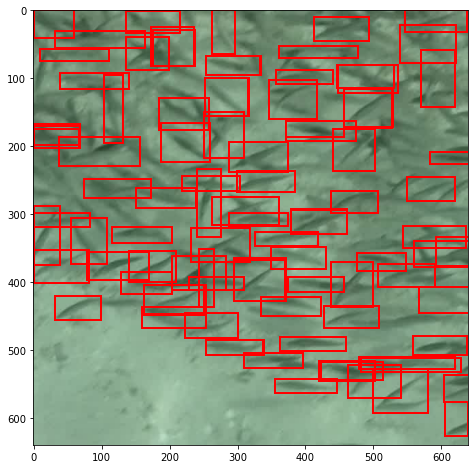

In [1]:
import cv2
import json
from ultralytics import YOLO  # Adjust the import according to how you import your model
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load your YOLOv8 model
model = YOLO('/Users/apaula/Downloads/fishschool-5test.pt')

def detect_and_draw_boxes_on_tile(image_path, model, tile_size=640, start_x=0, start_y=0):
    # Load the whole image
    image = cv2.imread(image_path)

    # Extract a 640x640 tile from the image
    tile = image[start_y:start_y + tile_size, start_x:start_x + tile_size]

    # Save the tile temporarily (required for your model's input format)
    temp_tile_path = 'temp_tile.jpg'
    cv2.imwrite(temp_tile_path, tile)

    # Run detection on the tile
    results = model(temp_tile_path)
    json_results = json.loads(results[0].tojson())

    # Prepare to draw bounding boxes on the tile using Matplotlib
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(cv2.cvtColor(tile, cv2.COLOR_BGR2RGB))  # Convert tile to RGB for Matplotlib

    for detection in json_results:
        box = detection['box']
        x1, y1, x2, y2 = int(box['x1']), int(box['y1']), int(box['x2']), int(box['y2'])
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

    # Cleanup: Delete the temporary tile file
    import os
    os.remove(temp_tile_path)

# Path to your whole picture
image_path = '/Users/apaula/Downloads/testframe.jpg'
detect_and_draw_boxes_on_tile(image_path, model)
